In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample

## Utils

In [3]:
def confusion_matrix(data,tree,class_label='CLASS'):
    #or set?
    #binary_problem
    positive_value = '>50K'
    negative_value = '<=50K'
    #[Actual >50k and predicted >50k, Actual 50k but predicted <50k][Actual<50k and predicted <50k, Actual <50k and predicted >50k]
    confusion_matrix=[[0,0],[0,0]]
    queries = data.iloc[:, :-1].to_dict(orient="records")
    for i in range(len(data)):
        prediction = tree_utils.predict(queries[i], tree)
        if data[class_label][i] == '>50K' and prediction == '>50K':
            #true_positive
            confusion_matrix[0][0]+=1
        if data[class_label][i] == '<=50K' and prediction == '<=50K':
            #true negative
            confusion_matrix[1][1]+=1
        if data[class_label][i] == '<=50K' and prediction == '>50K':
            #false_negative
            confusion_matrix[1][0]+=1
        if data[class_label][i] == '>50K' and prediction == '<=50K':
            #false_positive
            confusion_matrix[0][1]+=1
            
    print('data len=', len(data))
    return confusion_matrix

In [4]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [5]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
    print("confusion-matrix:", confusion_matrix(testing_data, trained_tree))
    print("confusion-matrix-training:", confusion_matrix(training_data, trained_tree))
    
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print("confusion-matrix:", confusion_matrix(testing_data, pruned_trained_tree))
    print("confusion-matrix-training:", confusion_matrix(training_data, pruned_trained_tree))
    print('\n')
#     pprint(pruned_trained_tree)

In [6]:
# default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
#                       dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
#                       dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]
default_heuristics = [dt_heur.mdl_simple]
def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Adult Dataset

## Data preparation

In [7]:
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,68,Local-gov,144761,HS-grad,9,Widowed,Protective-serv,Not-in-family,White,Male,0,1668,20,United-States,<=50K
1,38,Private,275338,Bachelors,13,Divorced,Sales,Unmarried,White,Female,1151,0,40,United-States,<=50K
2,47,State-gov,123219,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,38,United-States,>50K
3,62,Private,197918,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
4,42,Self-emp-not-inc,37618,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States,<=50K


In [8]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week', 'native-country' ,'CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,68,Local-gov,HS-grad,9,Widowed,Protective-serv,Not-in-family,White,Male,20,United-States,<=50K
1,38,Private,Bachelors,13,Divorced,Sales,Unmarried,White,Female,40,United-States,<=50K
2,47,State-gov,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,38,United-States,>50K
3,62,Private,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
4,42,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,60,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,36,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,>50K
32557,34,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,40,Mexico,<=50K
32558,27,Private,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Male,43,United-States,<=50K
32559,41,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Farming-fishing,Wife,White,Female,40,United-States,<=50K


In [9]:
adult_dataset.dropna(how='any', axis=0)
indexNames = adult_dataset[(adult_dataset['workclass'] == '?') | (adult_dataset['education'] == '?') | (adult_dataset['marital-status'] == '?') | (adult_dataset['occupation'] == '?') | (adult_dataset['relationship'] == '?') | (adult_dataset['race'] == '?') | (adult_dataset['sex'] == '?') | (adult_dataset['native-country'] == '?') ].index
# print(indexNames)
adult_dataset.drop(indexNames, inplace=True)
adult_dataset.head()
adult_dataset.reset_index(inplace=False)
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,68,Local-gov,HS-grad,9,Widowed,Protective-serv,Not-in-family,White,Male,20,United-States,<=50K
1,38,Private,Bachelors,13,Divorced,Sales,Unmarried,White,Female,40,United-States,<=50K
2,47,State-gov,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,38,United-States,>50K
3,62,Private,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
4,42,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,60,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,36,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,>50K
32557,34,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,40,Mexico,<=50K
32558,27,Private,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Male,43,United-States,<=50K
32559,41,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Farming-fishing,Wife,White,Female,40,United-States,<=50K


### Adult 70%

<=50K    10598
>50K      3477
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

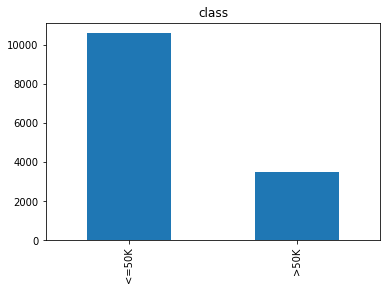

In [10]:
adult_set_for_training70, adult_testing70 = data_utils.data_split(adult_dataset, 70)
adult_training70, adult_validation70 = data_utils.split_training_data_for_pruning(adult_set_for_training70)

print(adult_training70['CLASS'].value_counts())
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

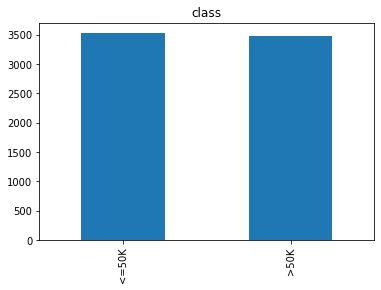

In [11]:
resampling_adult70 = adult_training70.copy()
less_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '<=50K']
more_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '>50K'] 

less_50k_part_downsampled70 = resample(less_50k_part70, 
                                 replace=False,    
                                 n_samples=3532)

# Combine minority class with downsampled majority class
balanced_adult_training70 = pd.concat([less_50k_part_downsampled70, more_50k_part70])
balanced_adult_training70 = balanced_adult_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training70 = balanced_adult_training70.sample(frac=1).reset_index(drop=True)

adult_training70 = balanced_adult_training70.copy()
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 80%

<=50K    12074
>50K      4011
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

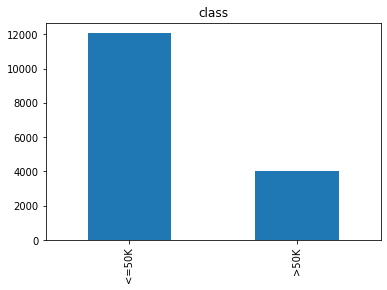

In [12]:
adult_set_for_training80, adult_testing80 = data_utils.data_split(adult_dataset, 80)
adult_training80, adult_validation80 = data_utils.split_training_data_for_pruning(adult_set_for_training80)

print(adult_training80['CLASS'].value_counts())
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

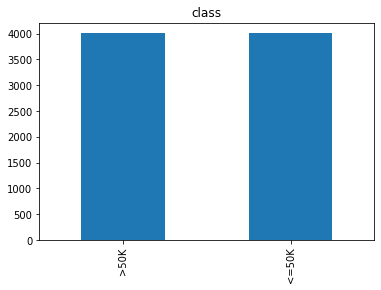

In [13]:
resampling_adult80 = adult_training80.copy()
less_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '<=50K']
more_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '>50K'] 

less_50k_part_downsampled80 = resample(less_50k_part80, 
                                 replace=False,    
                                 n_samples=4002)

# Combine minority class with downsampled majority class
balanced_adult_training80 = pd.concat([less_50k_part_downsampled80, more_50k_part80])
balanced_adult_training80 = balanced_adult_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training80 = balanced_adult_training80.sample(frac=1).reset_index(drop=True)

adult_training80 = balanced_adult_training80.copy()
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 90%

<=50K    13593
>50K      4503
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

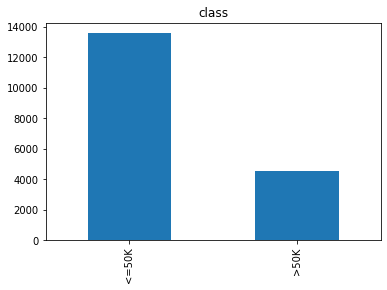

In [14]:
adult_set_for_training90, adult_testing90 = data_utils.data_split(adult_dataset, 90)
adult_training90, adult_validation90 = data_utils.split_training_data_for_pruning(adult_set_for_training90)

print(adult_training90['CLASS'].value_counts())
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

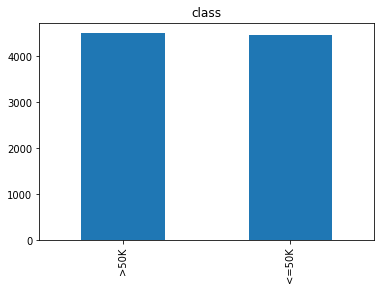

In [15]:
resampling_adult90 = adult_training90.copy()
less_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '<=50K']
more_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '>50K'] 

less_50k_part_downsampled90 = resample(less_50k_part90, 
                                 replace=False,    
                                 n_samples=4469)

# Combine minority class with downsampled majority class
balanced_adult_training90 = pd.concat([less_50k_part_downsampled90, more_50k_part90])
balanced_adult_training90 = balanced_adult_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training90 = balanced_adult_training90.sample(frac=1).reset_index(drop=True)

adult_training90 = balanced_adult_training90.copy()
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [16]:
# train_tree_for_different_heuristics(adult_training70, adult_testing70, adult_validation70)

Before Pruning - heuristic = mdl_simple
Accuracy for: testing 74.99% | training 80.14% | levels 14 | leafs 546
data len= 9049
confusion-matrix: [[1759, 416], [1669, 5027]]
data len= 7009
confusion-matrix-training: [[2866, 611], [781, 2751]]
After Pruning:
Accuracy for: testing 81.40% | training 73.59% | levels 12 | leafs 105
data len= 9049
confusion-matrix: [[1336, 901], [773, 6030]]
data len= 7009
confusion-matrix-training: [[2011, 1466], [385, 3147]]




In [17]:
train_tree_for_different_heuristics(adult_training80, adult_testing80, adult_validation80)

Before Pruning - heuristic = mdl_simple
Accuracy for: testing 76.38% | training 80.61% | levels 14 | leafs 470
data len= 6033
confusion-matrix: [[1250, 229], [1130, 3358]]
data len= 8013
confusion-matrix-training: [[3351, 660], [894, 3108]]
After Pruning:
Accuracy for: testing 80.28% | training 70.47% | levels 6 | leafs 64
data len= 6033
confusion-matrix: [[721, 784], [404, 4122]]
data len= 8013
confusion-matrix-training: [[1941, 2070], [296, 3706]]




In [18]:
# train_tree_for_different_heuristics(adult_training90, adult_testing90, adult_validation90)

Before Pruning - heuristic = mdl_simple
Accuracy for: testing 77.96% | training 80.06% | levels 14 | leafs 511
data len= 3017
confusion-matrix: [[594, 128], [507, 1758]]
data len= 8972
confusion-matrix-training: [[3685, 818], [971, 3498]]
After Pruning:
Accuracy for: testing 82.13% | training 71.11% | levels 6 | leafs 99
data len= 3017
confusion-matrix: [[380, 353], [185, 2098]]
data len= 8972
confusion-matrix-training: [[2289, 2214], [378, 4091]]


